In [1]:
import numpy as np
from geometricus import GeometricusEmbedding, MomentType, MomentInvariants
from caretta.app import app_helper
import prody as pd
from umap import UMAP
from pathlib import Path
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import networkx as nx
from cath_utils import cath
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2

In [2]:
pfam_to_pdb = app_helper.PfamToPDB(uri="https://raw.githubusercontent.com/TurtleTools/caretta/master/hmmer_pdb_all.txt")

In [10]:
!mkdir pfam_pdbs

In [35]:
populated_pfams = {k for k,v in pfam_to_pdb.pfam_to_pdb_ids.items() if len(v) > 100}
len(populated_pfams)

624

In [153]:
n = 0
for pfam_id in list(populated_pfams)[3:10]:
    for pdb_obj in pfam_to_pdb.pfam_to_pdb_ids[pfam_id]:
        n += 1
n

1537

In [44]:
list(populated_pfams)[2:3]

['PF01365.20']

In [154]:
# mappings = dict()
for pfam_id in list(populated_pfams)[3:10]:
    print(pfam_id)
    for pdb_obj in pfam_to_pdb.pfam_to_pdb_ids[pfam_id]:
        try:
            atoms, filename = pdb_obj.get_pdb()
            mappings[filename] = pfam_id
            pd.writePDB(f"./pfam_pdbs/{filename}", atoms)
        except:
            continue
        

PF02770.18
PF00186.18
PF00679.23
PF01196.18
PF16121.4
PF01590.25
PF01023.18


In [155]:
pfam_files = {x.split("/")[-1] for x in glob("./pfam_pdbs/*pdb")}
pfam_files

{'3JB9_B_840.pdb',
 '4AVU_A_963.pdb',
 '5WYJ_SF_212.pdb',
 '4V8Y_AE_212.pdb',
 '5AL4_A_963.pdb',
 '4V6O_BP_20.pdb',
 '3EIG_A_4.pdb',
 '5T9N_B_2159.pdb',
 '4HLM_A_963.pdb',
 '1NJB_A_5.pdb',
 '5MMM_O_30.pdb',
 '3UWL_A_4.pdb',
 '4V49_BL_20.pdb',
 '4V55_BN_20.pdb',
 '4V8C_A0_20.pdb',
 '1M7A_A_9.pdb',
 '2YWF_A_404.pdb',
 '3CE0_A_335.pdb',
 '3KJS_A_238.pdb',
 '3GQT_A_135.pdb',
 '1M31_A_5.pdb',
 '5DOY_1R_20.pdb',
 '4U24_BN_20.pdb',
 '4CFQ_A_5.pdb',
 '1JQM_B_600.pdb',
 '1RX8_A_1.pdb',
 '5EL6_55_20.pdb',
 '1CNP_A_7.pdb',
 '1IA2_A_9.pdb',
 '5X5D_A_32.pdb',
 '4HKI_A_963.pdb',
 '4UI7_A_963.pdb',
 '2RD8_B_32.pdb',
 '6DQJ_A_1189.pdb',
 '5XSR_A_152.pdb',
 '5OQL_m_212.pdb',
 '5TGM_S4_212.pdb',
 '4HL5_A_963.pdb',
 '3IY9_S_18.pdb',
 '5NWB_A_963.pdb',
 '5LZX_EE_212.pdb',
 '4N4T_A_1116.pdb',
 '3SR5_X_3.pdb',
 '2MAZ_A_9.pdb',
 '1QQQ_A_2.pdb',
 '5TB1_B_2159.pdb',
 '5TBW_F_212.pdb',
 '4V7L_BR_20.pdb',
 '3D6B_A_135.pdb',
 '1SYM_A_3.pdb',
 '1RH3_A_1.pdb',
 '3IK1_A_5.pdb',
 '2M7U_A_439.pdb',
 '3EON_A_135.pdb',


In [156]:
import pickle
pickle.dump(mappings, open("last_pfam_mapping.pkl", "wb"))

In [157]:
pdb_folder = "./pfam_pdbs/"
invariants = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.KMER,
                                        size=30)
single_invariant = invariants[list(invariants.keys())[0]]

invariants2 = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.RADIUS_UPSAMPLE,
                                              size=10)
invariants = {k: cath.concat_invariants(v, invariants2[k]) for k, v in invariants.items()}

In [158]:
updated_mappings = {k:v for k, v in mappings.items() if k in invariants}

In [169]:
train_data, test_data = cath.transform_geometricus_dataset_for_training(updated_mappings,
                                                                        invariants, batch_no=256)

In [170]:
torch.cuda.empty_cache()

In [172]:
model = cath.train_model(
    train_data,
    test_data,
    number_of_node_features=single_invariant.moments.shape[1],
    hidden_channels=128,
    number_of_classes=10,
    lr=0.0002,
    epochs=150,
)

Initial: Train Acc: 0.0439, Test Acc: 0.0250
Epoch: 010, Train Acc: 0.4803, Test Acc: 0.4819
Epoch: 020, Train Acc: 0.7192, Test Acc: 0.7075
Epoch: 030, Train Acc: 0.8453, Test Acc: 0.8394
Epoch: 040, Train Acc: 0.9319, Test Acc: 0.9213
Epoch: 050, Train Acc: 0.9518, Test Acc: 0.9291
Epoch: 060, Train Acc: 0.9595, Test Acc: 0.9369
Epoch: 070, Train Acc: 0.9684, Test Acc: 0.9413
Epoch: 080, Train Acc: 0.9734, Test Acc: 0.9456
Epoch: 090, Train Acc: 0.9752, Test Acc: 0.9500
Epoch: 100, Train Acc: 0.9803, Test Acc: 0.9525
Epoch: 110, Train Acc: 0.9855, Test Acc: 0.9587
Epoch: 120, Train Acc: 0.9888, Test Acc: 0.9703
Epoch: 130, Train Acc: 0.9897, Test Acc: 0.9731
Epoch: 140, Train Acc: 0.9911, Test Acc: 0.9753
Epoch: 149, Train Acc: 0.9914, Test Acc: 0.9781


In [71]:
cath_model = torch.load("embedder.pth")
cath_model.eval()

GCN(
  (conv1): GraphConv(32, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=116, bias=True)
)

In [72]:
def get_embedding(loaders, model):
    model.eval()
    res = list()
    labels = []
    predicted_labels = []
    for loader in loaders:
        for data in loader:
            data = data.cuda()
            out = model(data.x, data.edge_index, data.batch)
            res.append(out.cpu().detach().numpy())
            labels.append(data.y.reshape(out.shape[0], -1).argmax(dim=1).cpu().detach().numpy())
            predicted_labels.append(out.argmax(dim=1).cpu().detach().numpy())
    return np.concatenate(res), np.concatenate(labels), np.concatenate(predicted_labels)

In [73]:
import umap

In [185]:
pytorch_embedding, labels, pred = get_embedding([train_data, test_data], cath_model)
pytorch_embedding.shape, labels.shape, pred.shape

((1596, 116), (1596,), (1596,))

In [194]:
reducer = umap.UMAP(n_neighbors=100, metric="euclidean")
embedding = reducer.fit_transform(pytorch_embedding)

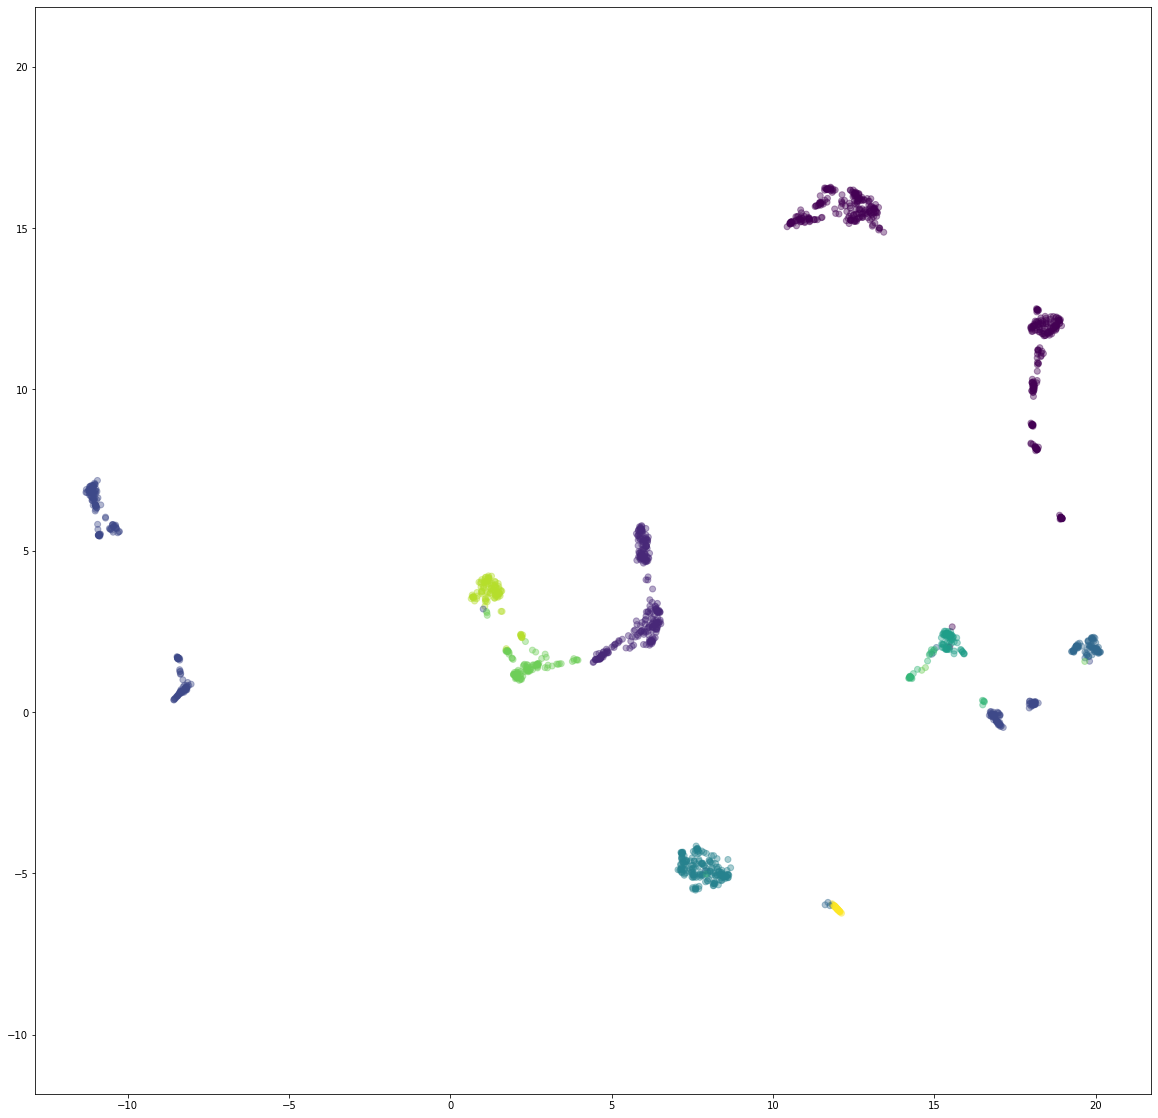

In [195]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels, alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')

In [173]:
pytorch_embedding, labels, pred = get_embedding([train_data, test_data], model)
pytorch_embedding.shape, labels.shape, pred.shape

((1596, 10), (1596,), (1596,))

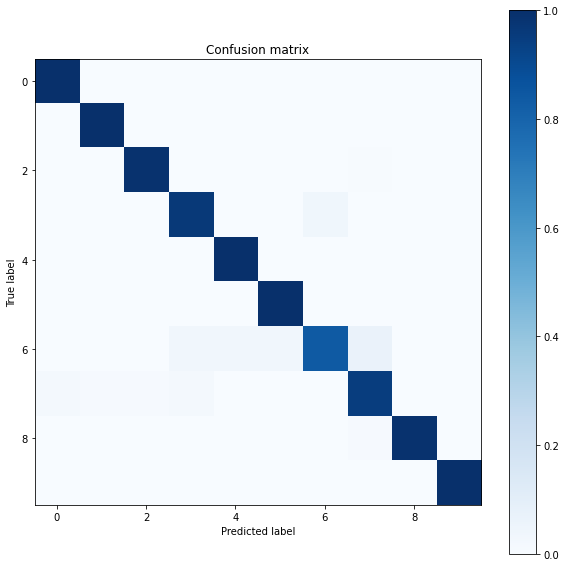

In [174]:
from sklearn.metrics import confusion_matrix
import itertools

confusionMatrix = confusion_matrix(labels, pred)

confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [175]:
reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

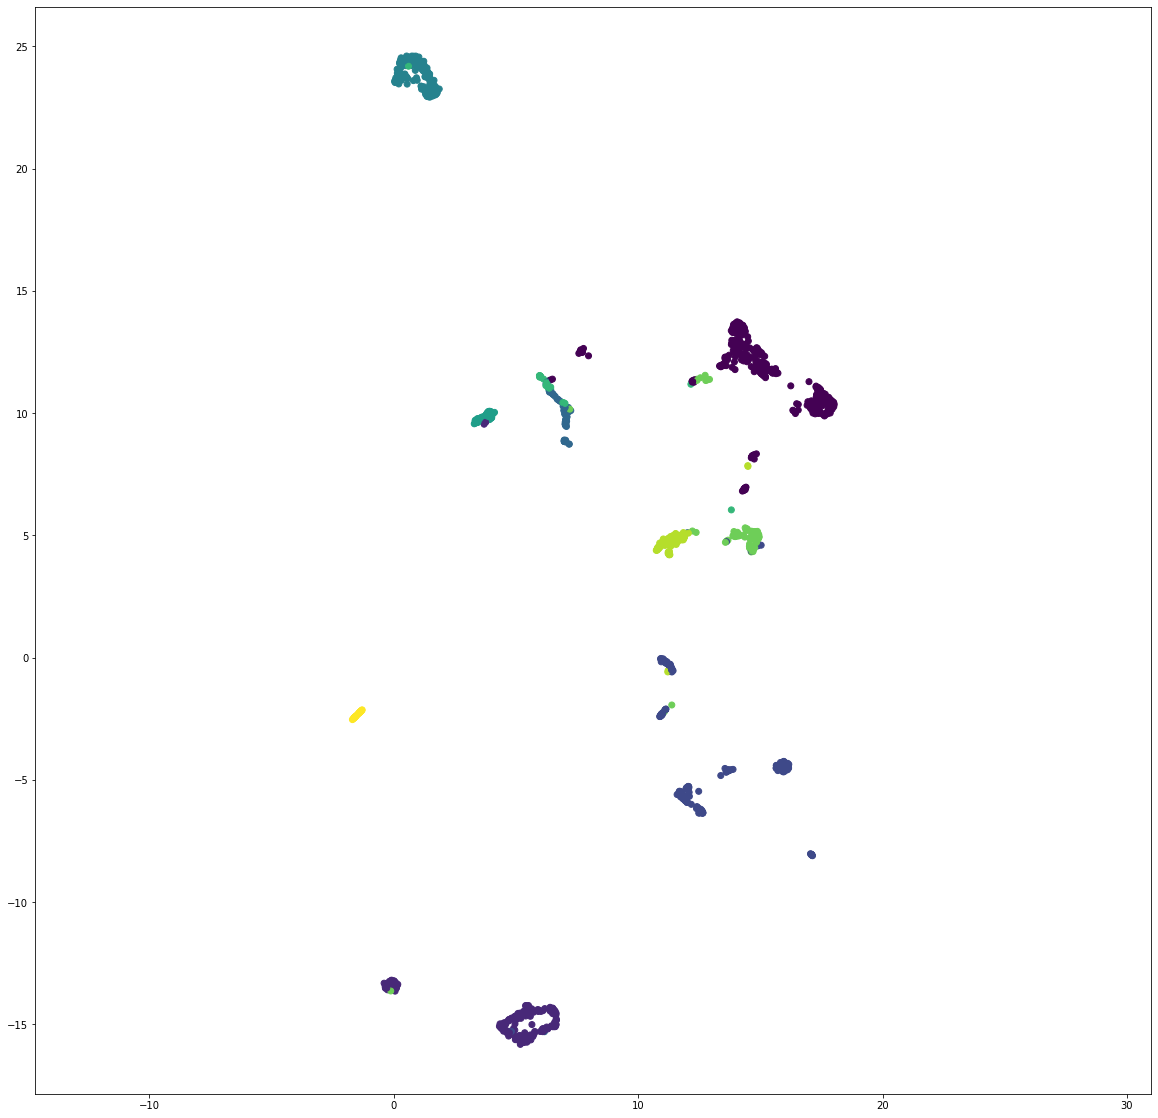

In [176]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

In [180]:
single_invariants = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.KMER,
                                        size=15)

In [181]:
embedder = GeometricusEmbedding.from_invariants([x for x in single_invariants.values()], resolution=1.)

/mnt/backup2/geometric/geo_env/lib/python3.8/site-packages/geometricus/geometricus.py:698: RuntimeWarning: invalid value encountered in log1p
  for x in (np.log1p(invariants[key].moments) * resolution).astype(int)


In [197]:
labels2 = [mappings[x] for x in single_invariants.keys()]
label_ids = dict()
n = 0
for label in labels2:
    if label not in label_ids:
        label_ids[label] = n
        n += 1

In [198]:
reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(embedder.embedding)

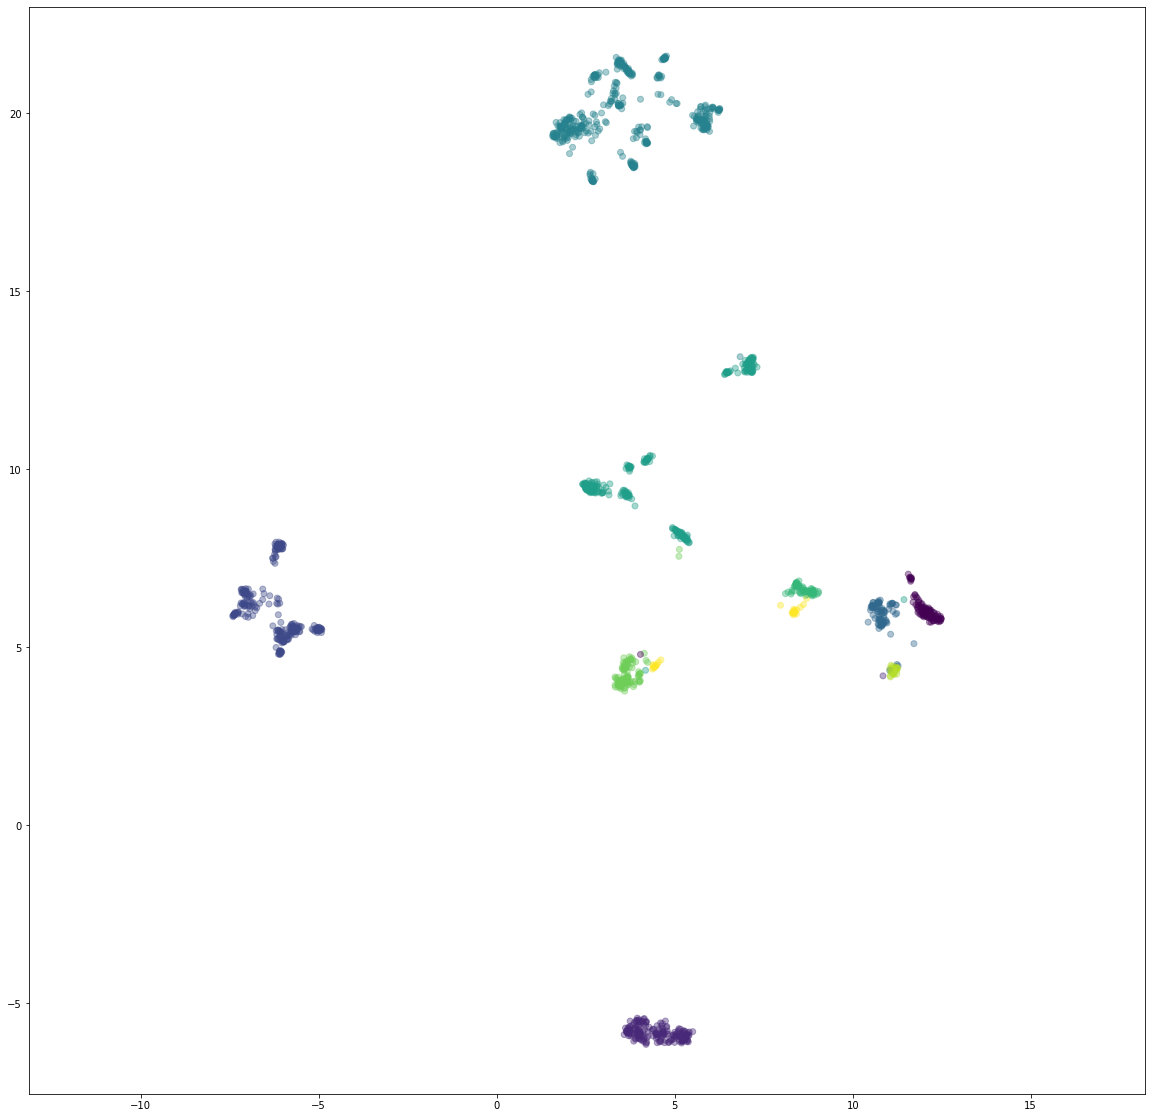

In [199]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[label_ids[x] for x in labels2],
    alpha=0.4)
plt.gca().set_aspect('equal', 'datalim')